# Step 3 - Converting your stellar models to photometric fluxes

In Step 1 we saw how to get hold of our stellar models and to put them in a usable form. In summary we had the following.

In [2]:
import numpy as np

wavelengths = np.arange(1000., 60000., 10.)

ages = np.arange(2, 53)
ages = 10**(6+0.1*(ages-2))

def get_model_grid():
    """ Loads up the BPASS grid of stellar models and
    resamples it onto a coarser wavelength grid. See Step 1."""
    
    model_path = "data/spectra-bin-imf135_300.z020.dat"
    raw_wavelengths = np.loadtxt(model_path, usecols=0)
    raw_grid = np.loadtxt(model_path)[:,1:]
    
    grid = np.zeros((wavelengths.shape[0], raw_grid.shape[1]))

    for i in range(grid.shape[1]):
        grid[:,i] = np.interp(wavelengths, raw_wavelengths, raw_grid[:,i])
    
    grid *= (3.827*10**33)/(10**6)

    return grid

grid = get_model_grid()

Then, in Step 2 we saw how to load filter curves and resample them in such a way they can be trivially integrated over our spectrum at different observed redshifts. Briefly we had the following.

In [3]:
# Load the curves up
filter_names = ["data/filters/CFHT_u.txt",
                "data/filters/CFHT_g.txt",
                "data/filters/CFHT_r.txt",
                "data/filters/CFHT_i+i2.txt",
                "data/filters/CFHT_z.txt",
                "data/filters/subaru_z",
                "data/filters/VISTA_Y.txt",
                "data/filters/VISTA_J.txt",
                "data/filters/VISTA_H.txt",
                "data/filters/VISTA_Ks.txt",
                "data/filters/IRAC1",
                "data/filters/IRAC2"]

filter_curves = []

for name in filter_names:
    filter_curves.append(np.loadtxt(name))
    
    
def blueshift_filters(redshift):
    """ A function that resamples filters onto the same wavelength
    basis as the model spectrum at the specified redshift. See Step 2. """
        
    resampled_filter_curves = []

    for filt in filter_curves:
        blueshifted_wavs = filt[:, 0]/(1 + redshift)
        
        resampled_filt = np.interp(wavelengths,
                                   blueshifted_wavs, filt[:, 1],
                                   left=0, right=0)
        
        resampled_filter_curves.append(resampled_filt)
        
    return resampled_filter_curves

Now we can think about how we're going to generate the photometry we want to fit to our observational data for a given redshift and age. All we really need to do is convert the luminosity units (erg/s/A per Solar mass of stars) into flux units (erg/s/cm^2/A per Solar mass of stars) at the observed redshift and integrate over the filter curves.

To convert to flux units at the observed redshifts we need to divide our luminosity by 4*pi*luminosity_distance(z)^2, and then divide by (1+redshift) to account for the spreading out of the light. We can calculate the luminosity distance using the astropy.cosmology module, we'll use redshift 1 for this example and take a random SSP from our model grid.

In [4]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

ssp_model = grid[:,25]

redshift = 1.

# Comes in megaparsecs
luminosity_distance = cosmo.luminosity_distance(redshift).value

cm_per_Mpc = 3.086*10**24

# Convert to centimetres
luminosity_distance *= cm_per_Mpc

# Spread out the total flux emitted across a sphere 
# with the luminosity distance as its radius.
ssp_model /= 4*np.pi*luminosity_distance**2

# Account for the fact the same amount of light is
# now spread out over a larger wavelength interval.
ssp_model /= (1 + redshift)

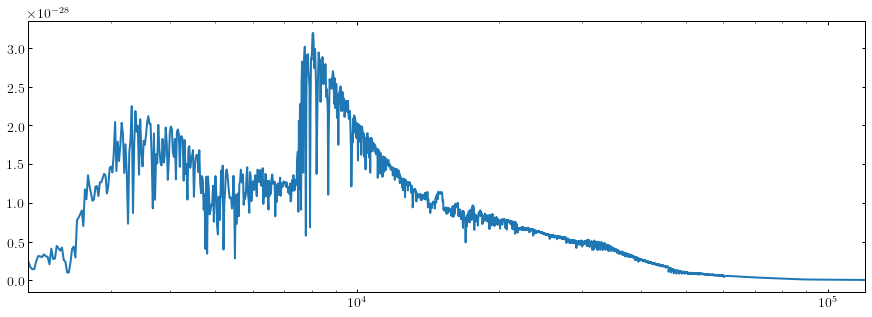

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(wavelengths*(1 + redshift), ssp_model)
plt.xscale("log")
plt.xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
plt.show()

Ok perfect, we have the spectrum in erg/s/cm^2/A per Solar mass of stars. Now let's turn this spectrum into photometric fluxes by integrating over our filters.

In [6]:
filter_curves_z = blueshift_filters(redshift)

photometry = np.zeros(len(filter_curves))

redshifted_wavs = wavelengths*(1 + redshift)

for i in range(photometry.shape[0]):
    flux_contributions = filter_curves_z[i]*ssp_model
    photometry[i] = np.trapz(flux_contributions, x=redshifted_wavs)
    photometry[i] /= np.trapz(filter_curves_z[i], x=redshifted_wavs)
    
print photometry

[1.70556390e-28 1.22418720e-28 1.21928408e-28 1.88638259e-28
 2.40590592e-28 2.32584522e-28 1.83593131e-28 1.28474056e-28
 8.88042928e-29 7.15361305e-29 3.80909712e-29 1.73792233e-29]


Great, now we know how to generate photometric fluxes! We can plot these on top of the spectrum to prove everything's working, we'll calculate the effective wavelengths of the filters quickly so we know where on the x axis the points go.

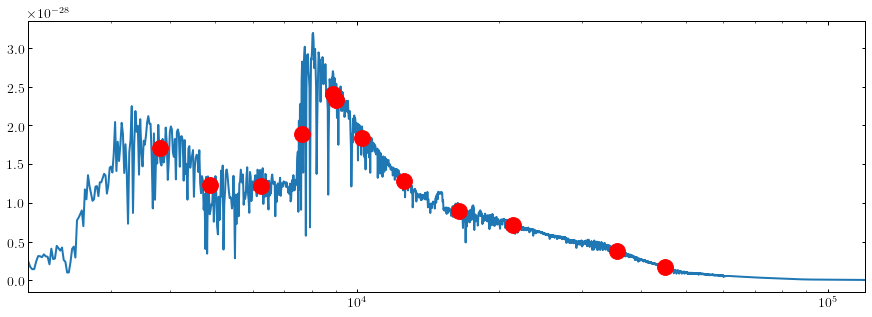

In [7]:
eff_wavs = np.zeros(len(filter_curves))

# Calculate the effective wavelengths of the filter curves
for i in range(len(filter_curves)):
    filt = filter_curves[i]

    wav_weights = filt[:,1]*filt[:,0]
    
    eff_wavs[i] = np.trapz(wav_weights, x=filt[:,0])

    eff_wavs[i] /= np.trapz(filt[:, 1], x=filt[:,0])

# Plot the model photometry over the model spectrum
plt.figure(figsize=(15, 5))
plt.plot(wavelengths*(1 + redshift), ssp_model)
plt.scatter(eff_wavs, photometry, color="red", s=250, zorder=10)
plt.xscale("log")
plt.xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
plt.show()